# Preparation

In [1]:
# Importing required libraries 
from tqdm import tqdm
import time
import numpy as np
import matplotlib.pyplot as plt
import random
import py_dss_interface

## DSS Interface Creation

In [2]:
dss = py_dss_interface.DSS()
#opendss_path = "C:/Users/jcuenca/AppData/Local/Programs/OpenDSS"
dss = py_dss_interface.DSS(opendss_path)

## Create DSS Model

In [3]:
# Master file path
#dss_file = "C:/Users/jcuenca/Documents/Tests/EDEN4SG/OpenDSS_DataGen/European_LV_DSS/Master_3ph.dss" 
# Compile and generate circuit
dss.text("compile {}".format(dss_file))
dss.text("solve")


''

# Dataset Generator (Guided - random steps)

## Parameters and initialise variables

In [4]:
# Variables
load_kw_rated = np.array(range(dss.loads.count), dtype=float)
amp_ratings = np.array(range(dss.lines.count), dtype=float)

# Extract base loads
dss.loads.first()
for load in (range(dss.loads.count)):
    load_kw_rated[load] = dss.loads.kw # Get nominal load rating
    dss.loads.next()

# Amp limits in lines
dss.lines.first()
for line in (range(dss.lines.count)):
    amp_ratings[line] = dss.lines.norm_amps # Get nominal load rating
    dss.lines.next()

# Volt limits in buses
max_v_pu =np.full((int(len(dss.circuit.buses_vmag_pu)/3)), 1.1) # Maximum voltage p.u. value is 1.1
min_v_pu =np.full((int(len(dss.circuit.buses_vmag_pu)/3)), 0.9) # Minimum voltage p.u. value is 0.9

# Number of loads
n_loads = dss.loads.count

# Set upper and lower bound for base loads (e.g., 20% - 450%)
max_loads = load_kw_rated*30
min_loads = load_kw_rated*0

# Set step for load changes (e.g., 500 W)
load_step = 0.5 

# Number of operational points (OP) to generate (i.e., dataset size)
#n_op = 1000000

# PF Simulator to label OPs

In [5]:
# Batch directory
batch_dir = (train_dir + "batches/")
N_batches = 1000 # This is done to improve performance of data generation

dss.text("set mode=snap")

state = 0 # Initialise categorical state (0=safe, 1=not-safe)
next_OP = np.copy(min_loads) # Initialise variable for next OP with the lowest possible state

#ALL_OPS = np.copy(next_OP) # Variable to store operational points (i.e., injections)
safe=0 # Counter for safe operational points
unsafe=0 # Counter for unsafe operational points

alllineamps = np.array(range(dss.lines.count), dtype=float) # Variable for all line currents (amps)
allbusvolts = np.array(range(len(dss.circuit.buses_vmag_pu)), dtype=float) # Variable for all bus voltages (p.u.)
allbusvolts = np.reshape(allbusvolts, (int(len(dss.circuit.buses_vmag_pu)/3), 3)) # Reshape from 3phase
allbusvolts = np.mean(allbusvolts, axis = 1) # Mean voltage of three phases

# Variables useful for training
#ALL_REGRESS = np.hstack([allbusvolts, alllineamps]) # Variable to store bus votlages and line currents for regression
#ALL_CLASSIF = np.empty(1)

# Start timers
t_data = 0
t_pf = 0
t_verif = 0
t_tot = 0
t_ini = perf_counter()

print("------- Generating data in batches -------")

for batch in tqdm(range(N_batches)):
    ALL_OPS = np.copy(next_OP)
    #ALL_REGRESS = np.hstack([allbusvolts, alllineamps]) # Variable to store bus votlages and line currents for regression ## UNCOMMENT FOR REGRESSION
    ALL_CLASSIF = np.empty(1)
    
    for op in (range(np.int32(n_op/N_batches))): # For each operational point do...

        t0 = perf_counter() # start timer
        
        # Assign load in electrical model
        dss.loads.first()
        for load in range(dss.loads.count):
            dss.loads.kw = next_OP[load]
            dss.loads.next()

        t1 = perf_counter() # time load changes
        
        # Solve PF for current OP
        dss.text("solve")

        t2 = perf_counter() # time power flow
        
        # Get current magnitudes (amperes)
        dss.lines.first()
        for line in range(dss.lines.count):
            alllineamps[line] = dss.cktelement.currents_mag_ang[0] 
            dss.lines.next()
        
        # Get voltage magnitudes p.u.
        allbusvolts = dss.circuit.buses_vmag_pu 
        allbusvolts = np.reshape(allbusvolts, (int(len(dss.circuit.buses_vmag_pu)/3), 3)) 
        allbusvolts = np.mean(allbusvolts, axis = 1)
            
        # Store voltage pu and current magnitudes 
        #allbusvolt_lineamps = np.hstack([allbusvolts, alllineamps]) # Store bus voltages and line currents ## UNCOMMENT FOR REGRESSION

        t3 = perf_counter() # timer obtain results    
        
        if all(alllineamps < amp_ratings) and all(allbusvolts < max_v_pu) and all(allbusvolts > min_v_pu) : # If constraints are respected do..-
            #print("safe")
            ALL_CLASSIF = np.vstack([ALL_CLASSIF, 0])  # Labelling safe point
            safe += 1 # Count safe scenarios 
            next_OP = next_OP + ((max_loads-(next_OP))*np.random.rand(dss.loads.count)) #+ (np.abs(dss.loads.kw))) # Add one load step to the node
                    
        else: # If at least one constraint is not respected do...
            #print("unsafe") # Count unsafe scenarios
            ALL_CLASSIF = np.vstack([ALL_CLASSIF, 1])  # Labelling unsafe point
            unsafe += 1 # Count unsafe scenarios 
            next_OP = next_OP - ((next_OP - min_loads) * np.random.rand(dss.loads.count)) #+ min_loads[node_change]) # Add one step to the load pool
            
        ALL_OPS = np.vstack([ALL_OPS, next_OP]) # Store OPs (injections)
        #ALL_REGRESS = np.vstack([ALL_REGRESS, allbusvolt_lineamps]) # Store regression values (volt pu and line currents amps) ## UNCOMMENT FOR REGRESSION
        
        t4 = perf_counter()

        t_data = t_data + t3 - t2 + t1 - t0
        t_pf = t_pf + t2 - t1
        t_verif = t_verif + t4 - t3

    #t_tot = t_tot + t4 - t_ini
    
    # Delete initialisation data row
    ALL_CLASSIF = np.delete(ALL_CLASSIF, 0, 0)
    #ALL_REGRESS = np.delete(ALL_REGRESS, 0, 0) ## UNCOMMENT FOR REGRESSION
    ALL_OPS = np.delete(ALL_OPS, -1, 0)

    # Get injections
    #ALL_OPS = np.loadtxt(open(data_directory + "input_injections_kW.csv", "rb"), delimiter=",", skiprows=0)
    np.savetxt(batch_dir + "A_" + str(batch) + ".csv", ALL_OPS, delimiter=",")
    #np.savetxt(batch_dir + "B_" + str(batch) + ".csv", ALL_REGRESS, delimiter=",") ## UNCOMMENT FOR REGRESSION
    np.savetxt(batch_dir + "C_" + str(batch) + ".csv", ALL_CLASSIF, delimiter=",")

t_tot = perf_counter() - t_ini

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [4:32:28<00:00, 16.35s/it]


## Analysis of computational time

In [ ]:
print("------- OpenDSS analysis -------")
print("To study", n_op, "operational points...")
print("Total execution time:", t_tot, "seconds")
print("Total data exchange time:", t_data, "seconds")
#print("Percentage :", 100*t_data/t_tot, "%")
print("Total power flow time:", t_pf, "seconds")
#print("Percentage :", 100*t_pf/t_tot, "%")
print("Total labellisation time:", t_verif, "seconds")
#print("Percentage :", 100*t_verif/t_tot, "%")
INFO_SIM = [n_op, unsafe, t_tot, t_data, t_pf, t_verif]

## Save the stored data

In [8]:
print("------- Regrouping batches -------")
ALL_OPS = np.copy(min_loads)
#ALL_REGRESS = np.hstack([allbusvolts, alllineamps]) # Variable to store bus votlages and line currents for regression## UNCOMMENT FOR REGRESSION
ALL_CLASSIF = 0

# Call the batches for storing
for batch in tqdm(range(N_batches)):
    ALL_OPS_save = np.loadtxt(open(batch_dir + "A_" + str(batch) + ".csv", "rb"), delimiter=",", skiprows=0)
    ALL_OPS = np.vstack([ALL_OPS, ALL_OPS_save])
    #ALL_REGRESS_save = np.loadtxt(open(batch_dir + "B_" + str(batch) + ".csv", "rb"), delimiter=",", skiprows=0) ## UNCOMMENT FOR REGRESSION
    #ALL_REGRESS = np.vstack([ALL_REGRESS, ALL_REGRESS_save]) ## UNCOMMENT FOR REGRESSION
    ALL_CLASSIF_save = np.loadtxt(open(batch_dir + "C_" + str(batch) + ".csv", "rb"), delimiter=",", skiprows=0)
    ALL_CLASSIF = np.hstack([ALL_CLASSIF, ALL_CLASSIF_save])
    
# Delete initialisation data row
ALL_CLASSIF = np.delete(ALL_CLASSIF, 0, 0)
#ALL_REGRESS = np.delete(ALL_REGRESS, 0, 0) ## UNCOMMENT FOR REGRESSION
ALL_OPS = np.delete(ALL_OPS, 0, 0)

# Store input, classification output and regression output
np.savetxt(train_dir + dataset_id + "/input_injections_kW.csv", ALL_OPS, delimiter=",")
#np.savetxt("D:/Data/ELVTN_Datasets/1_Random/output_regression_busvpu_lineamp.csv", ALL_REGRESS, delimiter=",") ## UNCOMMENT FOR REGRESSION
np.savetxt(train_dir + dataset_id + "/output_classification_notsafe.csv", ALL_CLASSIF, delimiter=",")
np.savetxt(train_dir + dataset_id + "/info.csv", INFO_SIM, delimiter=",")

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:54<00:00,  5.73it/s]


## Analysis of Operational Points Generated

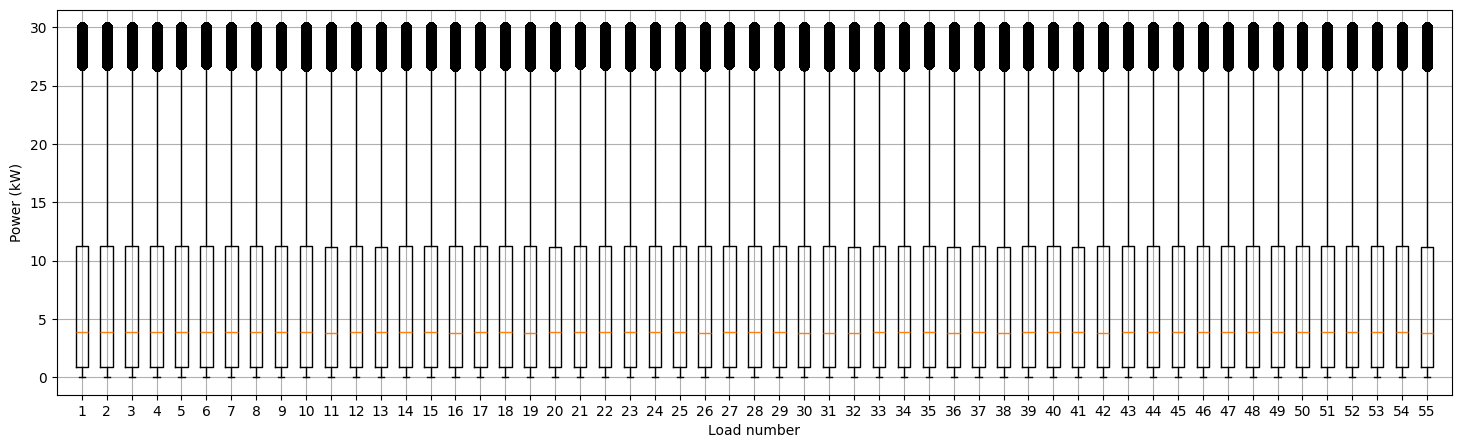

238136 safe operational points generated
761864 unsafe operational points generated
Of the  1000000  operational points generated,  0.0 % are repeated


In [9]:
# Count repeated points 
unq, count = np.unique(ALL_OPS, axis=0, return_counts=True)
print("Of the ", n_op, " operational points generated, ", len(unq[count>1])/n_op*100, "% are repeated")